Let's go.

In [19]:
import pandas as pd

In [20]:
def openData():
    df=pd.read_csv("../data.csv")
    return df
house=openData()
house.info()
house['age'] = (1403-house['buildYear']) # adding age for better corr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   meter      936 non-null    int64  
 1   district   936 non-null    object 
 2   buildYear  936 non-null    int64  
 3   rooms      934 non-null    float64
 4   price      936 non-null    int64  
 5   elevator   936 non-null    bool   
 6   space      936 non-null    bool   
 7   parking    936 non-null    bool   
 8   floor      899 non-null    float64
dtypes: bool(3), float64(2), int64(3), object(1)
memory usage: 46.7+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [21]:
print(house.describe())

            meter    buildYear       rooms         price       floor  \
count  936.000000   936.000000  934.000000  9.360000e+02  899.000000   
mean    96.277778  1393.166667    1.945396  1.167663e+10    3.880979   
std     53.036964     8.104399    0.738045  1.622517e+10    3.434442   
min      1.000000  1370.000000    1.000000  3.330000e+06    1.000000   
25%     61.000000  1386.000000    1.000000  3.500000e+09    2.000000   
50%     83.000000  1395.000000    2.000000  7.260000e+09    3.000000   
75%    115.000000  1401.000000    2.000000  1.380000e+10    4.000000   
max    650.000000  1403.000000    4.000000  2.200000e+11   27.000000   

               age  
count   936.000000  
mean    162.305556  
std     204.845293  
min       0.000000  
25%       4.000000  
50%      64.000000  
75%     289.000000  
max    1089.000000  


array([[<AxesSubplot: title={'center': 'meter'}>,
        <AxesSubplot: title={'center': 'buildYear'}>],
       [<AxesSubplot: title={'center': 'rooms'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'floor'}>,
        <AxesSubplot: title={'center': 'age'}>]], dtype=object)

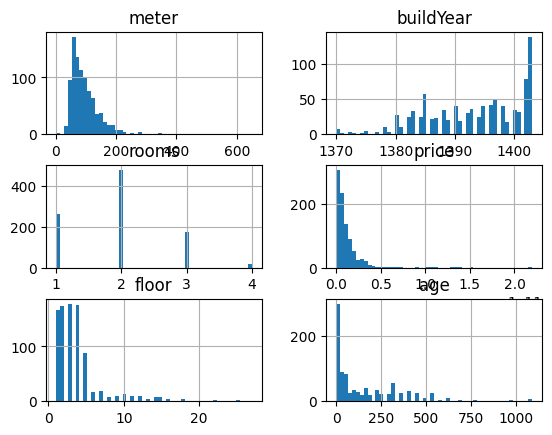

In [22]:
import matplotlib.pyplot as plt
house.hist(bins=50)
# plt.show()

**making the test set**

In [23]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [24]:
house_with_id = house.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

Text(0, 0.5, 'Number of districts')

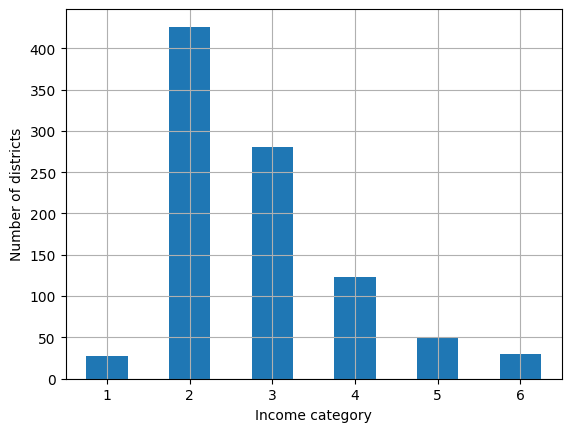

In [25]:
house["meter_cat"] = pd.cut(house["meter"],
bins=[0., 40, 80, 120, 160, 200., np.inf],
labels=[1, 2, 3, 4, 5, 6])
house["meter_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(house, house["meter_cat"]):
    stratTrainSetN = house.iloc[trainIndex]
    stratTestSetN = house.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]
print(stratTestSet["meter_cat"].value_counts() / len(stratTestSet))

2    0.457447
3    0.297872
4    0.132979
5    0.053191
6    0.031915
1    0.026596
Name: meter_cat, dtype: float64


In [27]:
stratTrainSet, stratTestSet = stratSplits[0]
print(stratTestSet["meter_cat"].value_counts() / len(stratTestSet))

2    0.457447
3    0.297872
4    0.132979
5    0.053191
6    0.031915
1    0.026596
Name: meter_cat, dtype: float64


In [28]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("meter_cat", axis=1 , inplace=True)

/tmp/ipykernel_8132/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)
/tmp/ipykernel_8132/117964952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("meter_cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [29]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

price        1.000000
meter        0.748767
rooms        0.546132
space        0.210793
elevator     0.204404
buildYear    0.133489
parking      0.120411
floor        0.044054
age         -0.099138
Name: price, dtype: float64


/tmp/ipykernel_8132/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


_note 1_ : wow it seems that meter is really important!

In [ ]:
house = stratTrainSet.drop('price',axis=1)
labels = stratTestSet['price'].copy()

imputation

In [ ]:
def imputeFrequent(cols,h):
    for col in cols:
        frequent = house[col].mode()
        h[col].fillna(frequent,inplace=True)
    return h
def imputeMean(cols,h):
    for col in cols:
        mean = int(house[col].mean())
        h[col].fillna(mean,inplace=True)
    return h
house = imputeFrequent(['floor','rooms','meter'], house)
house = imputeMean(['buildYear'], house)

*Handling district*

In [ ]:
from sklearn.preprocessing import OneHotEncoder
houseCategory=house[['district']]
housingOneHot = OneHotEncoder().fit_transform(houseCategory)
housingOneHot.toarray()

number attributes:

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

housingNumStd = std_scaler.fit_transform(house.select_dtypes(np.number))